### Anomaly Detection
在第三章，介紹了降維核心演算法，即使只有二維，演算法可以在不使用標籤的情況下有效的分離這些數字。非監督式的力量-學習最底層架構的資料並幫助找到非標籤的隱藏模式。

真實世界當中，資料集中被標籤的都是已經被抓到的，但還是有很多是沒辦法被發現的。而且詐騙的模式會一直在變動，監督式學習的模型建立(好比第二章建立的)沒辦法獲取最新的模式。

因此，在缺少有效標籤和需要新型的詐騙模式，非監督式學習就派上用場。


### 準備資料
把credit card transactions dataset 載入，生成特徵矩陣和標籤矩陣，分割成訓練和測試集。但我們不會使用標籤來實現異常偵測，但我們會使用標籤來評估模型。

有284807筆交易，492是詐騙。

總共有30個特徵-時間、數量、和28主成分。

訓練集192820筆交易(330筆交易是詐騙)

測試集93987(162筆詐騙)




In [16]:
import numpy as np 
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [17]:
import os
import pandas as pd

current_path = os.getcwd()
file = '\\datasets\\credit_card_data\\credit_card.csv'
data = pd.read_csv(current_path + file)

dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()


featuresToScale = dataX.columns


In [18]:

sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(
                                dataX[featuresToScale])

X_train, X_test, y_train, y_tet =  train_test_split(dataX, dataY, test_size=0.33,random_state=2018, stratify=dataY)

### Define anomaly score function
接下來，我們定義如何計算每筆交易的不正常性，

假設詐騙的交易很稀有而且和其他大多數的交易有不同的地方。

使用降維演算法最小化重塑所發生的錯誤。但是錯誤仍然會存在。

定義重塑的error的異常分數，每一筆的交易重塑錯誤是由原特徵矩陣和重塑矩陣之間的squared differences加總起來。利用max-min range來區分squared differences。

擁有最大平方差的交易會最接近1，也最接近詐騙交易。


In [19]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

### 定義評估矩陣 define evaluation metrics
雖然我們沒有使用詐騙的標籤來建立非監督式偵測解決方案，反而利用標籤來評估我們的模型。

和第二章一樣利用precision-recall curve 和平均精度 和 auROC來評估。



In [44]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

    if returnPreds==True:
        return preds

詐騙的標籤和評估的矩陣可以幫助我們知道非監督詐騙偵測系統可以抓取到詐騙的模式。但是我們沒有辦法評估這個系統在偵測未知詐騙模式是否也很好。
也就是說，資料集也可能存在著標籤是錯的情況。

### Define plotting function 


In [43]:
def scatterplot(xDF,yDF,algoName):
    tempDF = pd.DataFrame(data = xDF.loc[:,0:1],index=xDF.index)
    tempDF = pd.concat((tempDF,yDF),axis=1, join='inner')
    tempDF.columns=['First vector','second vector','Label']
    sns.lmplot(x='First vector', y = 'second vector', data = tempDF, hue = 'Label', fit_reg=False)
    plt.figure()
    ax = plt.gca()
    ax.set_title('Seperation of observations using' + algoName)

### Normal PCA Anomaly Detection 

使用PCA學習底層詐騙交易資料的的底層架構。利用學習過後的模型去重塑信用卡交易並且計算原交易和重塑後的交易有多少的相異之處。
PCA重塑最差的交易集最有可能是異常交易。


#### NOTES
記住我們得到信用卡交易資料集中的特徵是從金融公司得來的。針對以降維過的資料集降維的意義不大了。我們只是把原本主成分當作原特徵而已。

我們會參考原本主成分元素也就是原特徵集。在後面的所有主成分元素的敘述都是從PCA處理過後的元素而且原特徵集的主成分。

開始部屬更深刻了解降維的演算法可以幫助異常偵測。 異常偵測依靠著重塑產生的錯誤。我們想要稀少的交易中產生重塑錯誤reconstruction error。 這樣就可以知道那些交易最有可能是詐騙交易。重塑的錯誤越低，詐騙的機會就會高。

以PCA為例，重塑錯誤會根據主成分的數量我們不斷使用來重塑原交易。主成分越多，PCA的學習底層架構會越好。然而，總是有平衡點，過多的主成分，pca的重塑過程會過簡單，多到所有的交易的重塑錯誤都會變最小值。過少的主成分，PCA可能沒辦法重塑好任何一筆原交易(正常or不正常)。
來開始尋找最適當的主成分數量來保持最好的詐騙偵測系統!


#### PCA Components Equal Number of Original Dimensions

假設，我們希望使用PCA來生成和原特徵集相同數量的主成分元素，我們有辦法做異常偵測嗎?

想通答案應該很明顯，回想我們PCA的手寫例子。

當主成分的數量和原本維度的數量相同，PCA會從資料中抓取到幾乎100%的變異數(資訊)來產生主成分。因此，當PCA從主成分元素重新塑造這些交易，會有過低的重塑錯誤產生，讓我們沒辦法分辨出特異的交易和正常的交易，偵測結果不佳。

記住這些，開始應用PCA產生和原特徵集相同數量的主成分元素(30 特徵)，用fit_transform完成。為了要重塑原本特徵，會使用inverse_transform函式。


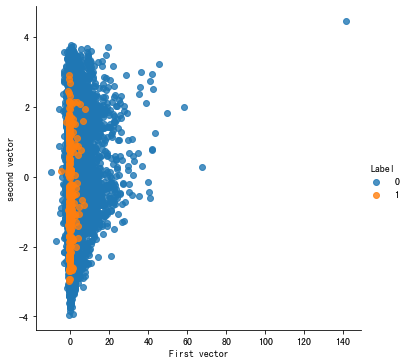

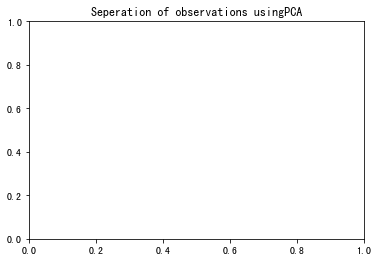

In [56]:
from sklearn.decomposition import PCA

n_components = 30
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterplot(X_train_PCA, y_train, "PCA")


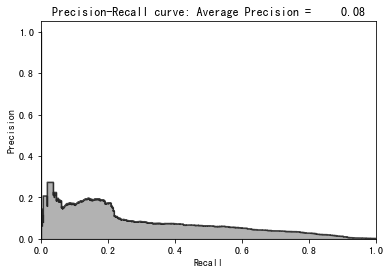

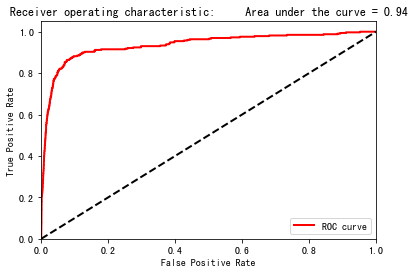

,trueLabel,anomalyScore
142087,0,1.000000
165168,0,0.854367
235908,0,0.330506
148255,0,0.313310
145672,0,0.065438
...,...,...
30023,0,0.000590
195475,0,0.001518
48687,0,0.000359
159608,0,0.000203


In [57]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)
preds[preds['trueLabel']==0]

In [58]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))

Precision:  0.18
Recall:  0.19


<Figure size 432x288 with 0 Axes>

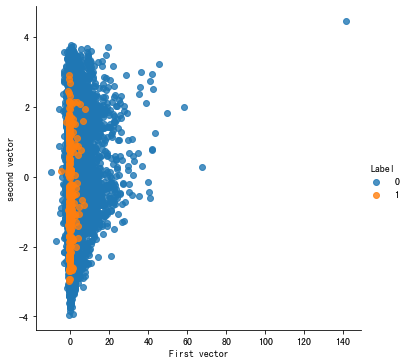

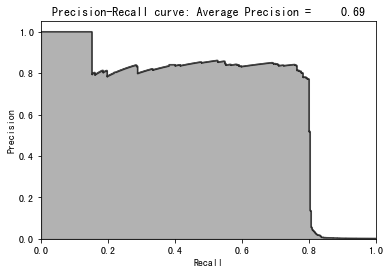

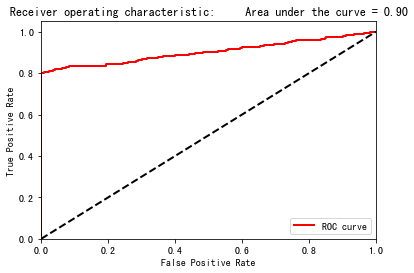

,trueLabel,anomalyScore
142087,0,0.000211
165168,0,0.000031
235908,0,0.000205
148255,0,0.000144
145672,0,0.000472
...,...,...
30023,0,0.000114
195475,0,0.000045
48687,0,0.000118
159608,0,0.000157


In [59]:
from sklearn.decomposition import PCA

n_components = 27
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

# par(mfrow = c(1,2)) 
plt.figure(3)
scatterplot(X_train_PCA, y_train, "PCA")

anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)
preds[preds['trueLabel']==0]

In [60]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))

Precision:  0.75
Recall:  0.8


<Figure size 432x288 with 0 Axes>

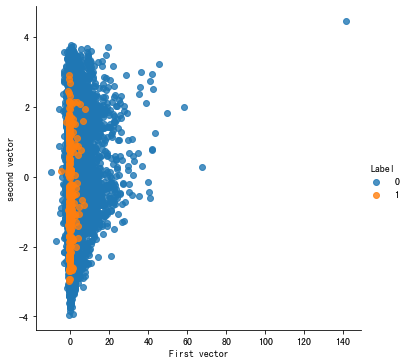

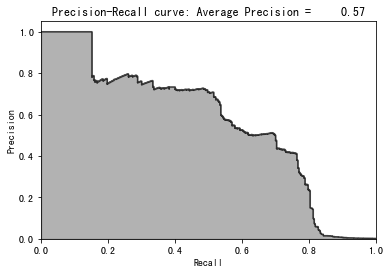

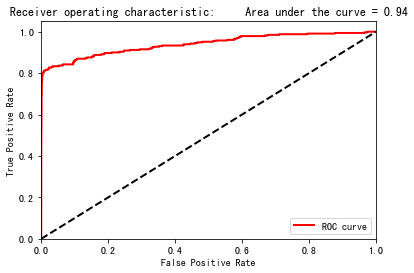

,trueLabel,anomalyScore
142087,0,0.000594
165168,0,0.000239
235908,0,0.000225
148255,0,0.000252
145672,0,0.000543
...,...,...
30023,0,0.000200
195475,0,0.000089
48687,0,0.000153
159608,0,0.000305


In [61]:
from sklearn.decomposition import PCA

n_components = 26
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

# par(mfrow = c(1,2)) 
plt.figure(3)
scatterplot(X_train_PCA, y_train, "PCA")

anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)
preds[preds['trueLabel']==0]

In [62]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))

Precision:  0.55
Recall:  0.58


尋找最優的主成分數量

現在降低數量來實驗驗證結果。 我們需要基於PCA的詐騙偵測解決方案在稀少案例上有足夠的error。但這error不可以太小或式太高。


Now, let’s perform a few experiments by reducing the number of principal components PCA generates and evaluate the fraud detection results. We need the PCA-based fraud detection solution to have enough error on the rare cases that it can meaningfully separate fraud cases from the normal ones. But the error cannot be so low or so high for all the transactions that the rare and normal transactions are virtually indistinguishable.

可以看到，我們能夠以75%準確度抓到80%的詐騙案，在未使用標籤的情況下這數據滿驚豔的。

To make these results more tangible, consider that there are 190,820 transactions in the training set and only 330 are fraudulent.

利用PCA，計算190820筆中每一筆的重塑error，如果由大到小去排列並萃取出最高350筆交易，可以獲得264筆詐騙案

Using PCA, we calculated the reconstruction error for each of these 190,820 transactions. If we sort these transactions by highest reconstruction error (also referred to as anomaly score) in descending order and extract the top 350 transactions from the list, we can see that 264 of these transactions are fraudulent.



That is a precision of 75%. Moreover, the 264 transactions we caught from the 350 we picked represent 80% of the total fraud in the training set (264 out of 330 fraudulent cases). And, remember that we accomplished this without using labels. This is a truly unsupervised fraud detection solution.
Here is the code to highlight this:

In [22]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))

Precision:  0.18
Recall:  0.19


Although this is a pretty good solution already, let’s try to develop fraud detection systems using some of the other dimensionality reduction methods.

雖然這樣已經是不錯的方案了。來試試看開發更好的偵測系統。(利用其他降為演算法)

#### Sparse PCA Anomaly Detection


Let’s try to use sparse PCA to design a fraud detection solution. Recall that sparse PCA is similar to normal PCA but delivers a less dense version; in other words, sparse PCA provides a sparse representation of the principal components.
We still need to specify the number of principal components we desire, but we must also set the alpha parameter, which controls the degree of sparsity. We will experiment with different values for the principal components and the alpha parameter as we search for the optimal sparse PCA fraud detection solution.
Note that for normal PCA Scikit-Learn used a fit_transform function to generate the principal components and an inverse_transform function to reconstruct the original dimensions from the principal components. Using these two functions, we were able to calculate the reconstruction error between the original feature set and the reconstructed feature set derived from the PCA.
Unfortunately, Scikit-Learn does not provide an inverse_transform function for sparse PCA. Therefore, we must reconstruct the original dimensions after we perform sparse PCA ourselves.
Let’s begin by generating the sparse PCA matrix with 27 principal components and the default alpha parameter of 0.0001:

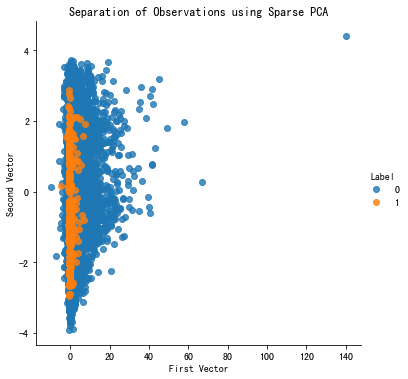

In [54]:
from sklearn.decomposition import SparsePCA
n_components = 27
alpha = 0.0001
random_state = 2018
n_jobs = -1

sparsePCA = SparsePCA(n_components=n_components, \
                alpha=alpha, random_state=random_state, n_jobs=n_jobs)

sparsePCA.fit(X_train.loc[:,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=X_train.index)

scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

Now let’s generate the original dimensions from the sparse PCA matrix by simple matrix multiplication of the sparse PCA matrix (with 190,820 samples and 27 dimensions) and the sparse PCA components (a 27 x 30 matrix), provided by Scikit-Learn library. This creates a matrix that is the original size (a 190,820 x 30 matrix). We also need to add the mean of each original feature to this new matrix, but then we are done.

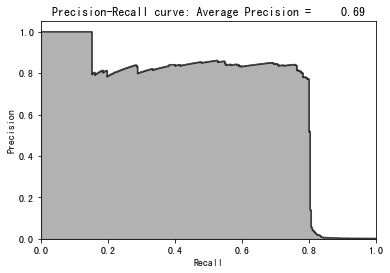

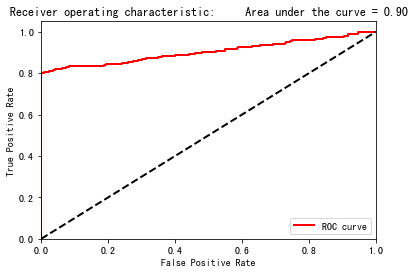

In [55]:
X_train_sparsePCA_inverse = np.array(X_train_sparsePCA). \
    dot(sparsePCA.components_) + np.array(X_train.mean(axis=0))
X_train_sparsePCA_inverse = \
    pd.DataFrame(data=X_train_sparsePCA_inverse, index=X_train.index)

anomalyScoresSparsePCA = anomalyScores(X_train, X_train_sparsePCA_inverse)
preds = plotResults(y_train, anomalyScoresSparsePCA, True)